# Pytanie badawcze

Jak zachowuje się długa, niska fala przy zbliżaniu do plaży (zmiany głębokości)?  
W szczególności:

- jak zmieniają się: **kształt**, **długość**, **amplituda** i **prędkość** fali,
- przy jakich głębokościach zaczyna się i kończy **shoaling** oraz jaka jest amplituda fali w momencie jego zakończenia.

In [29]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [30]:
from pint import UnitRegistry
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions


In [31]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, options: Options = None, bathymetry: np.ndarray, uh_initial: np.ndarray = None, vh_initial: np.ndarray = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid, n_threads = 1)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        if uh_initial is None:
            uh_initial = np.zeros(grid, dtype=float)
        if vh_initial is None:
            vh_initial = np.zeros(grid, dtype=float)
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_initial, **kwargs),
            "vh": ScalarField(vh_initial, **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        self.bathymetry = bathymetry

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        if np.amax(np.abs(courant_number)) > 1:
            print("Courant too big:", np.amax(np.abs(courant_number)))
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

In [ ]:
g = 10.0

# fizyczne jednostki
si = UnitRegistry()
Lx = 100 * si.m
Ly = 25 * si.m 

def x_phys(x_nd): return x_nd * Lx
def y_phys(y_nd): return y_nd * Ly
def h_phys(h): return h * si.m

def parameters_and_output(*, grid=(200, 50), dt_over_dxy=(0.1, 0.1),  amp_zeta=0.5,  b0=5.0,  nt=1000,  outfreq=3, grid_scale_factor=1, dt_scale_factor=1):
    nx0, ny0 = grid
    nx = nx0 * grid_scale_factor
    ny = ny0 * grid_scale_factor
    x_nd = np.linspace(0, 1, nx)

    Lx_val = Lx.magnitude
    Ly_val = Ly.magnitude
    dx_phys = Lx_val / nx   # [m]
    dy_phys = Ly_val / ny   # [m]

    x_bath = 0.5  # położenie przejścia dno głębokie/płycizna w skali bezywmiarowej
    width_b = 1/6    # szerokość strefy przejściowej w sklai bezwymiarowej
    bath_grad = b0 * 0.5 * (1 + np.tanh((x_bath - x_nd) / width_b))  # [m]
    bathymetry = np.tile(bath_grad[:, None], (1, ny))  # [m]

    x0 = 0.25 #[m]
    sigma = 0.05
    h_initial = bathymetry + amp_zeta * np.exp(-((x_nd - x0) ** 2) / (2 * sigma ** 2))[:, None]  # [m]

    zeta = h_initial - bathymetry #[m]
    c = np.sqrt(g * bathymetry) # [m/s]
    uh_initial = c * zeta  # [m^2/s]
    vh_initial = np.zeros_like(h_initial) #[m^2/s]

    c_max = np.sqrt(g * np.max(h_initial))  # [m/s]
    dt_over_dx  = dt_over_dxy[0]
    dt_phys_base = dt_over_dx  * dx_phys  / c_max # [s]
    dt_phys = dt_phys_base / dt_scale_factor  # [s]
    dt_over_dx = dt_phys / dx_phys # [s/m]
    dt_over_dy = dt_over_dx

    nt_ = int(nt * dt_scale_factor)
    outfreq_ = int(outfreq * dt_scale_factor)

    integrator = ShallowWaterEquationsIntegrator(
        h_initial=h_initial, # [m]
        bathymetry=bathymetry, # [m]
        uh_initial=uh_initial, # [m^2/s]
        vh_initial=vh_initial  # [m^2/s]
    )

    output = integrator(
        nt=nt_,
        g=g, 
        dt_over_dxy=(dt_over_dx, dt_over_dy),
        outfreq=outfreq_
    )
    t = np.arange(len(output['h'])) * dt_phys * outfreq_ #[s]

    return output, h_initial, bathymetry, uh_initial, vh_initial, t, x_nd


In [33]:
def zeta_max(output, bathymetry, x):
    nt = len(output["h"])
    ny = output["h"][0].shape[1]
    x_z_max = np.full(nt, np.nan)
    z_max = np.full(nt, np.nan)
    b_z_max = np.full(nt, np.nan)
    b =  bathymetry[:, ny//2]
    for it in range(nt):
        h = output["h"][it][:, ny//2]
        z = h - b
        idx_max = np.argmax(z)
        z_peak = z[idx_max]
        x_z_max[it] = x[idx_max]
        z_max[it] = z_peak
        b_z_max[it] = b[idx_max]
    return x_z_max, z_max, b_z_max

def shoaling_start(x_z_max, z_max, b_z_max, x_deep=0.4, scale_amp=1.05):
    deep_mask = x_z_max < x_deep
    z_deep = np.median(z_max[deep_mask])
    for i in range(len(z_max)):
        if x_z_max[i] >= x_deep and z_max[i] > scale_amp * z_deep:
            return i, b_z_max[i], z_max[i], z_deep
    return None, np.nan, np.nan, z_deep

def shoaling_end(output, bathymetry, x, start_idx, win_half=16, thr_asym=0.55):
    nt = len(output["h"])
    ny = output["h"][0].shape[1]
    for it in range(start_idx, nt):
        z = output["h"][it][:,  ny // 2] - bathymetry[:,  ny // 2]
        idx_max = np.argmax(z)
        L = max(0, idx_max - win_half)
        R = min(len(z), idx_max + win_half)
        z_loc = z[L:R]
        # weryfikacja czy w danym obszarze nie pojawił się artefakt w posatci 2 maksimów, nienaturalna deformacja fali
        dz = np.gradient(z_loc)
        if (np.sum((dz[:-1] > 0) & (dz[1:] < 0)) > 1):
            return it
        #weryfikacja aby nie bylo ogromnej asymetrii fali
        mid = len(z_loc) // 2
        A_left  = np.trapezoid(z_loc[:mid])
        A_right = np.trapezoid(z_loc[mid:])
        asym = abs(A_left - A_right) / max(A_left + A_right, 1e-12)
        if asym > thr_asym:
            return it
    return None

def amp_theory(res, x_deep=0.4):
    A_teor = []
    for i in range(len(res["b0"])):
        x_peak = np.asarray(res["x_peak"][i])
        z_peak = np.asarray(res["z_peak"][i])
        b_peak = np.asarray(res["b_peak"][i])
        end_i = res["end_i"][i]
        if end_i is None:
            A_teor.append(np.nan)
            continue
        mask = x_peak <x_deep
        A0 = np.median(z_peak[mask])
        h0 = res["b0"][i]
        h_end = b_peak[end_i]
        A_teor.append(A0*(h0/h_end)**0.25)
    return np.array(A_teor)

def run_shoaling_test(depth_list):
    b0_list, b_start_list, A_end_list = [], [], []
    start_i_list, end_i_list , b_end_list = [], [], []
    out_list, bathy_list, t_list = [], [], []
    xpeak_list, zpeak_list, bpeak_list = [], [], []
    for b in depth_list:
        out, h0, bathy, uh0, vh0, t, x = parameters_and_output(b0=b)
        x_peak, z_peak, b_peak = zeta_max(out, bathy, x)
        start_i, h_start, _, _ = shoaling_start(x_peak, z_peak, b_peak)
        end_i = shoaling_end(out, bathy, x, start_i)
        t_list.append(t)
        b0_list.append(bathy[:,  bathy.shape[1] // 2].max())
        b_start_list.append(h_start)
        start_i_list.append(start_i)
        out_list.append(out)
        bathy_list.append(bathy)
        end_i_list.append(end_i)
        A_end_list.append(z_peak[end_i] if end_i else np.nan)
        b_end_list.append(b_peak[end_i] if end_i else np.nan)
        xpeak_list.append(x_peak)
        zpeak_list.append(z_peak)
        bpeak_list.append(b_peak)
    return {"b0": b0_list, "b": b_start_list, "A": A_end_list, "start_i": start_i_list,
            "end_i": end_i_list, "x_peak": xpeak_list, "z_peak": zpeak_list, "b_peak": bpeak_list, "x_grid": x,
            "output": out_list, "bathy": bathy_list, "b_end":b_end_list, "t": t_list}

def breaking_teo(res):
    A_end = np.array(res["A"])
    b_end = np.array(res["b_end"])
    return A_end/b_end

def plot_shoaling_summary(res):
    depth_nd = np.array(res["b0"])
    b_start_nd = np.array(res["b"])
    b_end_nd = np.array(res["b_end"])
    A_end_nd = np.array(res["A"])
    A_theor_nd = amp_theory(res)
    ratio_breaking = breaking_teo(res)
    depth = h_phys(depth_nd).magnitude
    b_start = h_phys(b_start_nd).magnitude
    b_end = h_phys(b_end_nd).magnitude
    A_end = h_phys(A_end_nd).magnitude 
    A_theor = h_phys(A_theor_nd).magnitude 
    depth_unit = str(h_phys(1.0).units)
    amp_unit = depth_unit
    fig, (ax_left, ax_right) = pyplot.subplots(1, 2, figsize=(10,5))
    ax1 = ax_left
    ax2 = ax_left.twinx()
    l1 = ax1.plot(depth, b_start, "o--", label="shoaling start depth", color="blue")
    l2 = ax2.plot(depth, b_end, "x--", label="shoaling end depth", color="green")
    ax1.set_xlabel(f"Initial depth b₀ [{depth_unit}]")
    ax1.set_ylabel(f"Depth at shoaling start [{depth_unit}]", color="blue")
    ax2.set_ylabel(f"Depth at shoaling end [{depth_unit}]", color="green")
    ax1.grid(True)
    ax2.grid(True)
    left_lines = l1 + l2
    ax1.legend(left_lines, [ln.get_label() for ln in left_lines])
    ax3 = ax_right
    ax4 = ax_right.twinx()
    l3 = ax3.plot(depth, A_end, "s--", color="red", label="A end")
    l4 = ax3.plot(depth, A_theor, "d--", color="darkred", label="A theory")
    l5 = ax4.plot(depth, ratio_breaking, "^-", color="black", label="A(x_end)/b(x_end)")
    ax3.set_xlabel(f"Initial depth b₀ [{depth_unit}]")
    ax3.set_ylabel(f"Amplitude A [{amp_unit}]", color="red")
    ax4.set_ylabel("A / b (dimensionless)", color="black")
    ax3.grid(True)
    ax4.grid(True)
    right_lines = l3 + l4 + l5
    ax3.legend(right_lines, [ln.get_label() for ln in right_lines])
    pyplot.tight_layout()
    fig.suptitle("Rysunek 4. Początek i koniec shoalingu, amplituda A oraz stosunek A/h (kryterium Miche’a).", y=1.02)
    pyplot.show()


In [34]:
def limits(output, bathymetry):
    z = output['h'] - bathymetry
    return z.min(), z.max()

def plot_profile_with_amplitude(output, bathy, frames, colors, ampl_max, start_idx, end_idx):
    vmin, vmax = limits(output, bathy)
    ny = output["h"][0].shape[1]
    nx = output["h"][0].shape[0]
    x = np.linspace(0, 1, nx)
    x = x_phys(x)
    vmin = h_phys(vmin)
    vmax = h_phys(vmax)
    x_unit = str(x_phys(1.0).units)
    z_unit = str(h_phys(1.0).units)
    fig, ax = pyplot.subplots(1, 2, figsize=(15,4))
    a1 = ax[0]
    for c, f in zip(colors, frames):
        z = output["h"][f][:, ny//2] - bathy[:, ny//2]
        z = h_phys(z)
        a1.plot(x.magnitude, z.magnitude, color=c, label=f"time step = {f}")
    a1.set_xlabel(f"x [{x_unit}]")
    a1.set_ylabel(f"ζ [{z_unit}]")
    a1.set_ylim(vmin.magnitude, vmax.magnitude)
    a1.grid(True)
    a1.legend()
    a1b = a1.twinx()
    b = h_phys(bathy[:, ny//2])
    a1b.plot(x.magnitude, b.magnitude, color="black", linestyle="--")
    a1b.set_ylabel(f"b [{z_unit}]")
    a1b.invert_yaxis()
    a2 = ax[1]
    ampl_phys = h_phys(np.array(ampl_max))
    steps = np.arange(len(ampl_max))
    a2.plot(steps, ampl_phys.magnitude, label="ζ_max(step)")
    if start_idx is not None:
        a2.axvline(start_idx, color='green', linestyle='--', label="shoaling start")
    if end_idx is not None:
        a2.axvline(end_idx, color='red', linestyle='--', label="shoaling end")
    a2.set_xlabel("time step")
    a2.set_ylabel(f"ζ_max [{z_unit}]")
    a2.grid(True)
    a2.legend()
    fig.suptitle("Rysunek 2. Profil ζ(x) i ewolucja amplitudy w czasie dla b₀ = 3 m.")
    pyplot.tight_layout()
    return fig

def plot_zeta_heatmap(output, bathymetry, frame_L, frame_R):
    vmin, vmax = limits(output, bathymetry)
    vmin = h_phys(vmin)
    vmax = h_phys(vmax)
    z_unit = str(h_phys(1.0).units)
    x_unit = str(x_phys(1.0).units)
    y_unit = str(y_phys(1.0).units)
    Lx_val = x_phys(1.0).magnitude
    Ly_val = y_phys(1.0).magnitude
    extent = [0.0, Lx_val, 0.0, Ly_val]
    fig, axes = pyplot.subplots(1, 2, figsize=(16, 4))
    for ax, frame in zip(axes, [frame_L, frame_R]):
        z = output["h"][frame] - bathymetry
        z = h_phys(z)
        im = ax.imshow(z.T.magnitude, origin="lower", cmap="viridis", aspect="auto", vmin=vmin.magnitude, vmax=vmax.magnitude, extent=extent)
        ax.set_title(f"ζ(x, y), step = {frame}")
        ax.set_xlabel(f"x [{x_unit}]")
        ax.set_ylabel(f"y [{y_unit}]")
        fig.colorbar(im, ax=ax, label=f"ζ [{z_unit}]")
    fig.suptitle("Rysunek 1. Heatmapa wysokości powierzchni swobodnej ζ(x, y) dla b₀ = 3 m.")
    pyplot.tight_layout()
    return fig


def plot_v_u(output, bathymetry, frame_L, frame_R, step=4):
    ny = output["h"][0].shape[1]
    nx = output["h"][0].shape[0]
    x = x_phys(np.linspace(0, 1, nx))
    y = y_phys(np.linspace(0, 1, ny))
    x_unit = str(x.units)
    y_unit = str(y.units)
    fig, axes = pyplot.subplots(1, 2, figsize=(16, 4))
    for ax, frame in zip(axes, [frame_L, frame_R]):
        h  = output["h"][frame]
        uh = output["uh"][frame]
        vh = output["vh"][frame]
        u = uh/h
        v = vh/h
        X, Y = np.meshgrid(x.magnitude[::step], y.magnitude[::step], indexing='ij')
        ax.quiver(X, Y, u[::step, ::step], v[::step, ::step], width=0.003, scale_units="xy")
        ax.set_title(f"Velocity field, time step = {frame}")
        ax.set_xlabel(f"x [{x_unit}]")
        ax.set_ylabel(f"y [{y_unit}]")
        ax.set_aspect("equal")
        ax.grid(True, alpha=0.3)
    fig.suptitle("Rysunek 3. Pole prędkości (u, v) dla dwóch wybranych chwil czasowych.", y=1.02)
    pyplot.tight_layout()
    return fig

In [35]:
def dx_dt_changed(grid_factor=1, dt_factor=1): return parameters_and_output(grid_scale_factor=grid_factor,dt_scale_factor=dt_factor)

def zeta_frame(output, bathymetry, frame):
    ny = output['h'][0].shape[1]
    return output['h'][frame][:, ny // 2] - bathymetry[:, ny // 2]

def convergence_check(frames):
    o1, _, b1, _, _, t1, x1 = dx_dt_changed(1, 1)
    o2, _, b2, _, _, t2, x2 = dx_dt_changed(2, 1)
    o3, _, b3, _, _, t3, x3 = dx_dt_changed(1, 2)
    o4, _, b4, _, _, t4, x4 = dx_dt_changed(2, 2)

    outputs = [o1, o2, o3, o4]
    baths   = [b1, b2, b3, b4]
    x_grids = [x1, x2, x3, x4]
    times   = [t1, t2, t3, t4]

    labels  = ["dx/1, dt/1", "dx/2, dt/1", "dx/1, dt/2", "dx/2, dt/2"]
    styles  = ["-", "--", ":", "-."]
    colors  = ["black", "red", "blue", "magenta"]

    x_ref_phys = x_phys(x1).magnitude
    x_unit = str(x_phys(1.0).units)
    z_unit = str(h_phys(1.0).units)

    n_frames = len(frames)
    fig, axes = pyplot.subplots(1, n_frames, figsize=(6 * n_frames, 4))
    if n_frames == 1:
        axes = [axes]
    for ax, frame in zip(axes, frames):
        frame_idx_ref = min(frame, len(times[0]) - 1)
        t_target = times[0][frame_idx_ref]
        for out, bath, xg, lab, ls, col, t_arr in zip(
                outputs, baths, x_grids, labels, styles, colors, times):
            idx = int(np.argmin(np.abs(t_arr - t_target)))
            ny = out["h"][0].shape[1]
            z = out["h"][idx][:, ny // 2] - bath[:, ny // 2] 
            z_phys = h_phys(z).magnitude
            xg_phys = x_phys(xg).magnitude
            z_interp = np.interp(x_ref_phys, xg_phys, z_phys)
            ax.plot(x_ref_phys, z_interp, color=col, linestyle=ls, alpha=0.8, label=lab)

        ax.set_xlabel(f"x [{x_unit}]")
        ax.set_ylabel(f"ζ(x) [{z_unit}]")
        ax.grid(True, alpha=0.3)
        ax.set_title(f"t ≈ {t_target:.2f} s")
        ax.legend(fontsize=8)
    fig.suptitle("Rysunek 5. Test zbieżności: profil ζ(x) dla różnych dx i dt.", y=1.02)
    pyplot.tight_layout()
    return fig


In [36]:
def plot_initial_parametes():
    output, h_initial, bathymetry, uh_initial, vh_initial, t, x = parameters_and_output()
    b = -bathymetry[:, 0]
    z = h_initial[:, 0] - bathymetry[:, 0]
    x = np.arange( output['h'][0].shape[0])
    pyplot.figure(figsize=(14.5,3))
    pyplot.axis('off')

    arrow_kwargs = {'length_includes_head': True, 'head_width': 2, 'head_length': 0.01, 'width': 0.01, 'overhang': 0}

    ix = output['h'][0].shape[0] // 4 - 20; color='brown'; label='$b$'
    pyplot.fill_between(x, b, b.min()-0.3, color=color, label=f'$z=-${label}', alpha=.5)
    pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
    pyplot.annotate(f" {label}", xy=(x[ix], (z[ix]+b[ix])/2), color=color)

    ix = output['h'][0].shape[0] // 4; color='blue'; label=r'$\zeta$'
    pyplot.fill_between(x, z, b, color=color, label=f'$z=${label}', alpha=.1)
    pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
    pyplot.annotate(f" {label}", xy=(x[ix], z[ix] - 0.01), color=color)

    ix = output['h'][0].shape[0] // 4 + 20; color='black'; label='$h$'
    pyplot.plot(x, np.full_like(x, 0), linestyle='--', color=color, label='$z=0$')
    pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
    pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
    pyplot.annotate(f" {label}", xy=(x[ix], (z[ix]+b[ix])/2), color=color)

    pyplot.legend(loc="upper right")
    show_plot('symbols')


# Przedstawienie wyników i dyskusja
#### Parametry początkowe i geometria: 

Symulację prowadzono w prostokątnej domenie o długości $L_x = 100\,\mathrm{m}$ i szerokości $L_y = 25\,\mathrm{m}$, na siatce $200 \times 50$ punktów, przy $g = 10\,\mathrm{m/s^2}$ Początkowa fala ma kształt gaussowski o amplitudzie $\zeta_0 = 0{,}5\,\mathrm{m}$, z maksimum w okolicy $x = 0{,}25L_x$ i szerokości rzędu $5\,\mathrm{m}$ (parametr $\sigma = 0{,}05$). Prędkość w kierunku $x$ dobrano zgodnie z prędkością fali długiej $u(x) \approx \sqrt{g\,h(x)}$, a składowa w $y$ początkowo jest równa zero. Batymetria opisuje przejście z części głębszej do płytszej za pomocą funkcji typu $\tanh$, ze strefą przejściową szerokości około $L_x/6$. Maksymalna głębokość $b_0$ przyjmuje wartości $2, 3, 4, 6, 8$ oraz $10\,\mathrm{m}$.


In [37]:
#plot_initial_parametes()

#### Wyznaczenie początku i końca shoalingu oraz wizualizacja: 

Początek shoalingu definiujemy jako moment, gdy amplituda fali rośnie o co najmniej 5% względem mediany amplitudy na wodzie głębokiej. Koniec shoalingu wyznaczamy jako chwilę, w której fala staje się niefizycznie stroma: maksimum przesuwa się na sam przód fali, a profil zaczyna przypominać „ostry pik” zamiast fali tuż przed załamaniem. Do wykrycia tego momentu użyto dwóch kryteriów: liczby pików w lokalnym oknie oraz asymetrii kształtu fali. Poniżej przedstawiono heatmapę $\zeta(x,y)$, przekrój $\zeta(x)$ oraz pole prędkości $u(x,y), v(x,y)$ dla przypadku $b_0 = 3\,\mathrm{m}$.

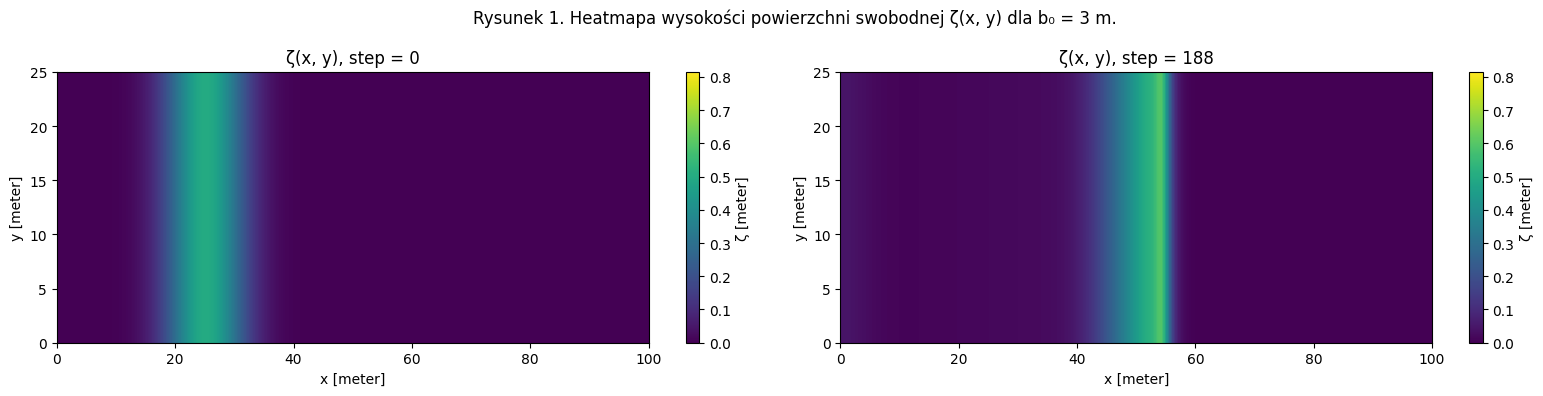

In [38]:
results = run_shoaling_test([2,3,4,5,6,7,8])
i = 2; pyplot.show(plot_zeta_heatmap(results["output"][i], results["bathy"][i], 0, results["end_i"][i]))

Heatmapa $\zeta(x,y)$ (rys. 1) pokazuje, jak w trakcie propagacji fala skraca się, jej front staje się coraz bardziej stromy, a amplituda rośnie z ok. $0{,}5\,\mathrm{m}$ do ok. $0{,}6\,\mathrm{m}$. Potwierdza to, że shoaling prowadzi do zwiększenia wysokości fali i jej wyraźnej deformacji w rejonie przybrzeżnym.

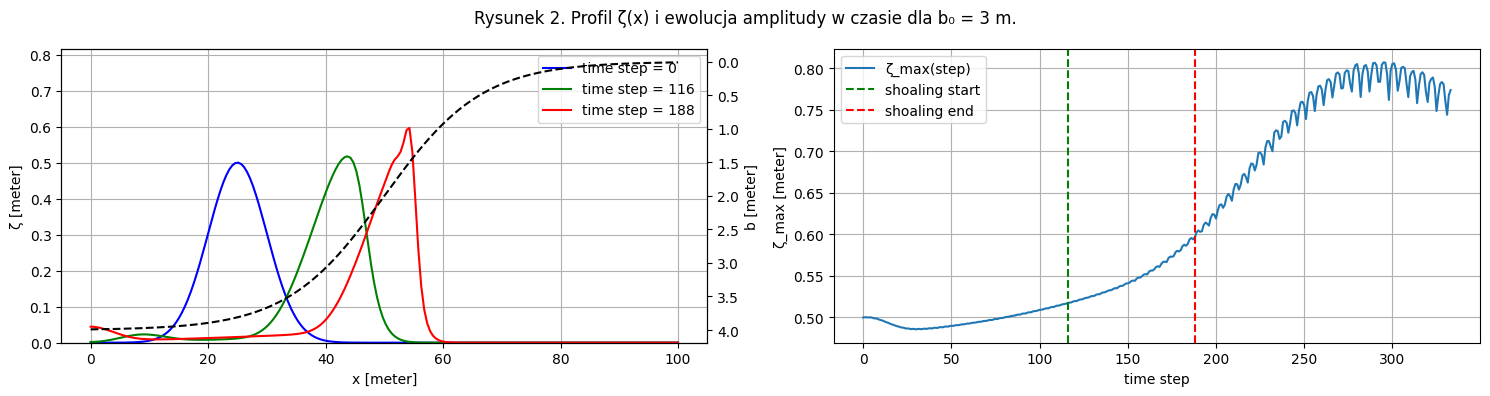

In [39]:
pyplot.show(plot_profile_with_amplitude(results["output"][i], results["bathy"][i], [0, results["start_i"][i], results["end_i"][i]], ["blue","green","red"], results["z_peak"][i], results["start_i"][i], results["end_i"][i]))


Wykresy przekrojów $\zeta(x)$ (rys. 2) potwierdzają poprawność wyznaczenia początku i końca shoalingu: początek wiąże się z niewielkim, ale wyraźnym wzrostem amplitudy, zgodnie z przyjętym progiem. Przy końcu shoalingu fala jest już silnie zdeformowana, a maksimum przesuwa się na sam przód, co odpowiada chwili tuż przed fizycznym breakingiem. Po tym momencie na przebiegu amplitudy pojawiają się gwałtowne oscylacje numeryczne, co uzasadnia przyjęcie tej chwili jako końca shoalingu.

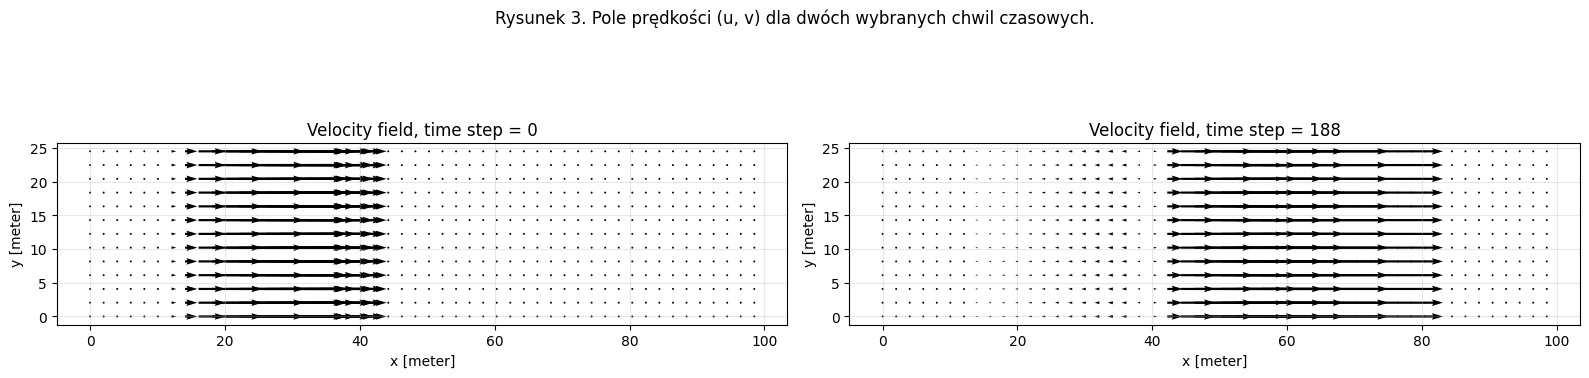

In [40]:
pyplot.show(plot_v_u(results["output"][i], results["bathy"][i], 0, results["end_i"][i]))

Na wykresie prędkości (rys. 3) może wydawać się, że fala przyspiesza na płyciznach, jednak zgodnie z teorią prędkość propagacji fali jako całości maleje z głębokością ($c = \sqrt{g h}$). Widoczny lokalny wzrost prędkości dotyczy jedynie cząstek wody w stromym froncie fali: podczas shoalingu fala rośnie i staje się bardziej stroma, energia jest skupiana w mniejszej objętości, a przepływ wewnątrz fali zostaje silnie wypchnięty do przodu.

#### Zależność początku/końca shoalingu oraz amplitudy końcowej od maksymalnej głębokości: 

Z wykresów (rys. 4) wynika, że wraz ze wzrostem początkowej głębokości $b_0$ głębokość, przy której rozpoczyna się shoaling, rośnie prawie liniowo (nachylenie mniejsze niż 1). Fale powstające na większej głębokości muszą więc dotrzeć proporcjonalnie płycej, aby pojawił się wyraźny wzrost stromości. Dla końca shoalingu zależność jest wyraźnie nieliniowa: dla małych $b_0$ głębokość końcowa zmienia się szybko, natomiast dla większych wartości krzywa się wypłaszcza. Oznacza to, że fale z głębokiej wody wcześniej osiągają stan bliski załamaniu i kończą shoaling przy relatywnie wyższych głębokościach. Amplituda końcowa rośnie wraz z $b_0$, co jest zgodne z zachowaniem energii fali – przy spadku prędkości na płyciźnie wysokość fali wzrasta. Otrzymane wartości dobrze zgadzają się z prawem Green’a dla fal długich $A(h) = A_0 \left( \frac{h_0}{h} \right)^{1/4}$, liczonym w wyznaczonej głębokości końca shoalingu. Analizowany stosunek $\frac{A(x_{\text{end}})}{b(x_{\text{end}})}$ pozostaje bliski progowi załamania fal płytkowodnych z kryterium Miche’a $\frac{H}{h} \le 0{,}88$ (gdzie $H = 2A$), co odpowiada warunkowi $\frac{A}{h} \le 0{,}44$. Niewielkie odchylenia od wartości $0{,}44$ wskazują, że w chwili wyznaczonego końca shoalingu fala w symulacji osiąga stan bardzo bliski fizycznego załamania.

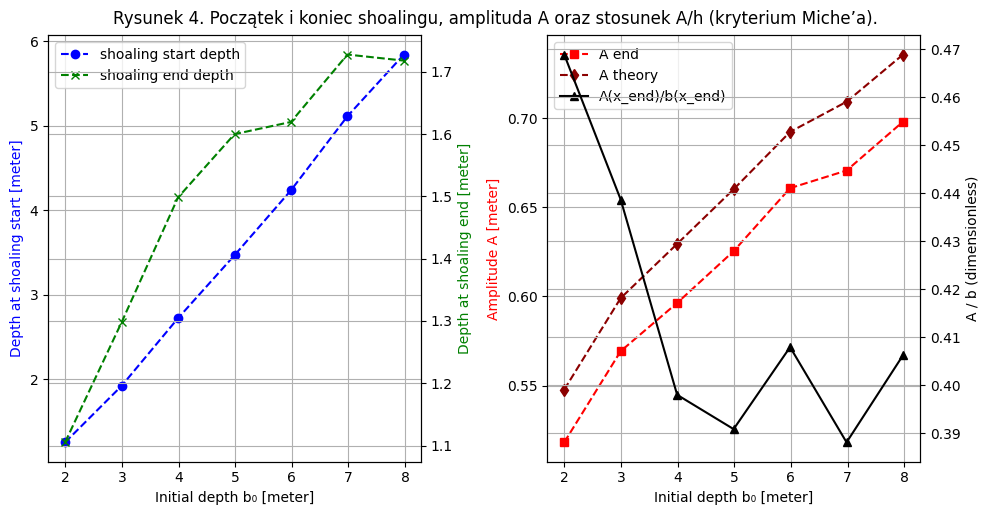

In [41]:
plot_shoaling_summary(results)

#### 2.4. Analiza zbieżności: 

Porównanie profili $\zeta(x)$ (rys. 5) dla dwóch gęstości siatki ($dx$ i $dx/2$) oraz dwóch kroków czasu ($dt$ i $dt/2$) w kilku chwilach symulacji pokazuje, że krzywe praktycznie na siebie nachodzą. Różnice pojawiają się tylko lokalnie w najbardziej stromym fragmencie fali, tuż przed końcem shoalingu. Potwierdza to zbieżność rozwiązania, a także to, że konfiguracja bazowa ($dx/1, dt/1$) jest wystarczająco dokładna i poprawnie odtwarza oczekiwane zachowanie fizyczne fali.

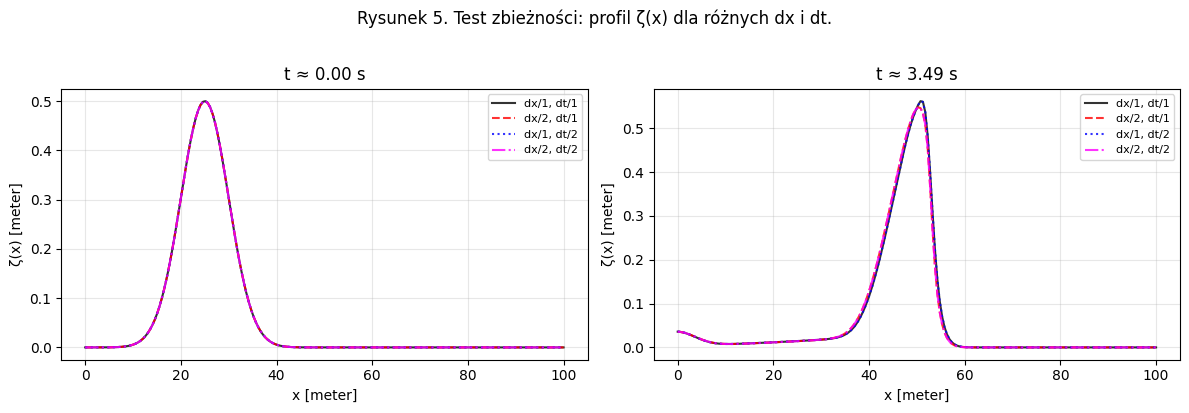

In [42]:
pyplot.show(convergence_check([0,169]))

# Podsumowanie odpowiedzi na pytania badawcze


**1. Jak zmienia się fala przy zbliżaniu do płycizny?**

- Fala skraca się i staje się coraz bardziej asymetryczna: strome czoło, maksimum przesunięte na przód.
- Amplituda rośnie a wyniki pokrywaja się z prawem Green’a.
- Prędkość propagacji fali maleje jak $c=\sqrt{g h}$, natomiast lokalna prędkość cząstek we froncie rośnie.

**2. Na jakiej głębokości zaczyna i kończy się shoaling? Jaka jest amplituda na końcu?**

- Początek shoalingu: głębokość startu rośnie liniowo z $b_0$ (nachylenie < 1, czyli fale z większej głębokości muszą dojść płycej, by zaczął się wyraźny wzrost stromości).
- Koniec shoalingu: głębokość końcowa rośnie z $b_0$ nieliniowo (dla małych $b_0$ zmienia się szybko, dla większych wartości krzywa się wypłaszcza).
- Stosunek $A/h$ w punkcie końca shoalingu jest bliski $0{,}4$, czyli zbliżony do progu załamania fal płytkowodnych z kryterium Miche’a.
